Dependencies

In [ ]:
!pip install gymnax
!pip install distrax

In [ ]:
from gymnax.experimental import RolloutWrapper
# action = self.model_forward(policy_params, obs, rng_net)
import functools
import gymnax
from typing import Union,Optional,Any
import abc

import jax
import jax.numpy as jnp
from flax import nnx

class UnsupervisedExplorer(nnx.Module):

    @abc.abstractmethod
    def update(self,obs,actions,next_obs,dones,info):
      #update variable parameters
        return #{"kl":KL} MI = E KL

    @abc.abstractmethod
    def __call__(self,observations,rng):

        return #actions, {"mi":mi_matrix}

from gymnax.environments.environment import Environment
class CustomRolloutWrapper:
    """Wrapper to define batch evaluation for generation parameters."""

    def __init__(
        self,
        env_or_name: Union[str,Environment] = "Pendulum-v1",
        num_env_steps: Optional[int] = None,
        env_kwargs: Any | None = None,
        env_params: Any | None = None,
    ):
        """Wrapper to define batch evaluation for generation parameters."""
        # Define the RL environment & network forward function
        if env_kwargs is None:
            env_kwargs = {}
        if env_params is None:
            env_params = {}
        if isinstance(env_or_name,Environment):
            self.env = env_or_name
            self.env_params = env_or_name.default_params
        else:
            self.env, self.env_params = gymnax.make(env_or_name, **env_kwargs)
        self.env_params = self.env_params.replace(**env_params)

        if num_env_steps is None:
            self.num_env_steps = self.env_params.max_steps_in_episode
        else:
            self.num_env_steps = num_env_steps

#    @functools.partial(nnx.jit, static_argnums=(0,))
    def batch_reset(self,rng_input):
        batch_reset = jax.vmap(self.single_reset_state)
        return batch_reset(rng_input)

 #   @functools.partial(nnx.jit, static_argnums=(0,))
    def single_reset_state(self,rng_input):
        rng_reset, rng_episode = jax.random.split(rng_input)
        obs, state = self.env.reset(rng_reset, self.env_params)
        return state

   # @functools.partial(nnx.jit, static_argnums=(0,4))
    def batch_rollout(self, rng_eval, model:UnsupervisedExplorer,
                      env_state=None,num_steps=1):
        """Evaluate a generation of networks on RL/Supervised/etc. task."""
        # vmap over different MC fitness evaluations for single network
        batch_rollout = jax.vmap(self.single_rollout, in_axes=(0, None,0,None))
        return batch_rollout(rng_eval, model, env_state,num_steps)

    # @functools.partial(nnx.jit, static_argnums=(0,4))
    def single_rollout(self, rng_input, model:UnsupervisedExplorer,
                       env_state=None,num_steps=1):
        """Rollout a pendulum episode with lax.scan."""
        # Reset the environment
        rng_reset, rng_episode = jax.random.split(rng_input)

        if env_state is None:
            obs, env_state = self.env.reset(rng_reset, self.env_params)
        else:
            obs = self.env.get_obs(env_state)

        def policy_step(state_input, _):
            """lax.scan compatible step transition in jax env."""
            obs, state,  rng, cum_reward, valid_mask = state_input
            rng, rng_step, rng_net = jax.random.split(rng, 3)
            if model is not None:
                action,info = model( obs, rng_net)
            else:
                action = self.env.action_space(self.env_params).sample(rng_net)
                info = {}
        #    print ("policy step action",action.shape)
            next_obs, next_state, reward, done, step_info = self.env.step(
                rng_step, state, action, self.env_params
            )
            info.update(step_info)
            new_cum_reward = cum_reward + reward * valid_mask
            new_valid_mask = valid_mask * (1 - done)
            carry = [
                next_obs,
                next_state,
                rng,
                new_cum_reward,
                new_valid_mask,
            ]
            y = [obs, action, reward, next_obs, done, state, info]
            return carry, y

        # Scan over episode step loop
        carry_out, scan_out = jax.lax.scan(
            policy_step,
            [
                obs,
                env_state,
                rng_episode,
                jnp.array([0.0]),
                jnp.array([1.0]),
            ],
            (),
            num_steps,
        )
        # Return the sum of rewards accumulated by agent in episode rollout
        obs, action, reward, next_obs, done, state, info = scan_out
        cum_return = carry_out[-2]
        info["last_state"] = carry_out[1]
        return obs, action, reward, next_obs, done,state, info, cum_return



In [ ]:
import jax
import jax.numpy as jnp
import jax.nn as nn
from flax import nnx

jnp.set_printoptions(precision=3,suppress=True)
from flax.training import train_state
from jax.scipy.special import gamma,digamma, gammaln, kl_div

def batch_random_split(batch_key,num=2):
    split_keys = jax.vmap(jax.random.split,in_axes=(0,None))(batch_key,num)
    return [split_keys[:, i]  for i in range(num) ]
@jax.jit
def compute_info_gain_normal(mean,prec,l_prec, next_obs):
    """
    mean: (batch, obs_dim)
    prec: (batch, obs_dim)  N(u;mean(s,a),(prec(s,a))^-0.5) N(next_obs;u,(l_prec(s,a))^-0.5)
    l_prec: (batch, obs_dim)    likelihood_precision
    next_obs: (batch, obs_dim)

    output: (batch)
    """

    prec = jnp.maximum(prec, 1e-6)
    posteior_prec = prec + l_prec
    prec_ratio = prec / posteior_prec

    posterior_mean = (prec * mean + next_obs * l_prec) /posteior_prec

    delta_mean =  next_obs - posterior_mean

    kl  = delta_mean * delta_mean * prec   #* ( l_prec / posteior_prec ) ** 2
    kl = kl + prec_ratio - jnp.log(prec_ratio) - 1
    kl = 0.5 * jnp.sum(kl,axis=-1)
    return kl, delta_mean

@jax.jit
def compute_expected_info_gain_normal(prec,l_prec):
    """
    prec: (batch, obs_dim)
    l_prec: (batch, obs_dim)    likelihood_precision

    output: (batch)
    """


    prec = jnp.maximum(prec, 1e-6)
    prec_ratio = l_prec / prec
    mi_matrix = 0.5 * jnp.sum( jnp.log(1+prec_ratio),axis=-1)
    return mi_matrix

class UnsupervisedRolloutWrapper(CustomRolloutWrapper):

 #   @functools.partial(nnx.jit, static_argnums=(0,))
    def batch_update(self, rng_update,model, obs, action,next_obs,done,info):
        if model is None: return {}
        return model.update(rng_update,obs, action,next_obs,done,info)

class RandomExplorer(UnsupervisedExplorer):

    def __init__(self, num_actions):
        self.num_actions = num_actions

    def update(self,rng,obs,action,next_obs,done,info):
      #update variable parameters
        return {} #MI = E KL

    def __call__(self,observations,rng):
        if observations.ndim == 1:
            actions = jax.random.randint(rng, (), 0, self.num_actions)
            return actions, {}
        actions = jax.random.randint(rng, (observations.shape[0],), 0, self.num_actions)
        return actions, {}

class JointEncoder(nnx.Module):
    def __init__(self, hidden_dims: int, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(hidden_dims,hidden_dims,rngs=rngs)
        self.linear2 = nnx.Linear(hidden_dims,hidden_dims,rngs=rngs)
        self.layer_norm0 = nnx.LayerNorm(hidden_dims,rngs=rngs)
        self.layer_norm1 = nnx.LayerNorm(hidden_dims,rngs=rngs)
        self.layer_norm2 = nnx.LayerNorm(hidden_dims,rngs=rngs)
        self.layer_norm3 = nnx.LayerNorm(hidden_dims,rngs=rngs)

    def __call__(self, x: jax.Array,rng):


        dist_distrax =  distrax.MultivariateNormalDiag(x,1e-1*jnp.ones_like(x))
        x = dist_distrax.sample(seed=rng, sample_shape=())
        x = self.layer_norm0(x)
        h0 = self.linear1(x)
        h = nn.relu(h0)
        h = self.layer_norm1(h) +h0
        h0 = self.linear2(h)
        h = self.layer_norm2(h)+h0
        return  self.layer_norm3(h)

class Encoder(nnx.Module):
    def __init__(self, input_dim: int, hidden_dims: int, rngs: nnx.Rngs):
        self.linear = nnx.Linear(input_dim,hidden_dims,rngs=rngs)
        self.layer_norm0 = nnx.LayerNorm(hidden_dims,rngs=rngs)

    def __call__(self, x: jax.Array):
        h = self.linear(x)
        return  self.layer_norm0(h)

class ActionEncoder(nnx.Module):
    def __init__(self, num_actions: int, hidden_dims: int, rngs: nnx.Rngs):
        self.embed = nnx.Embed(num_actions,hidden_dims,rngs=rngs)
        self.layer_norm0 = nnx.LayerNorm(hidden_dims,rngs=rngs)
    def __call__(self, x: jax.Array):
        return  self.layer_norm0(self.embed(x))
from jax import lax
import distrax

class Actor(nnx.Module):
    log_std_min: float = -4
    log_std_max: float = 2

    def __init__(self, obs_dim, action_dim,hidden_dim, rngs: nnx.Rngs):

        self.mean = nnx.Linear(hidden_dim, action_dim, rngs=rngs)
        self.log_std = nnx.Linear(hidden_dim, action_dim, rngs=rngs)

   #     self.linear1 = nnx.Linear(hidden_dim, action_dim, rngs=rngs)

    def __call__(self, x: jnp.ndarray):
     #   print ("x",x.shape)
        mean = self.mean(x)
      #  print ("mean",mean.shape)
        log_std = self.log_std(x)
       # print ("log_std",log_std.shape)
        log_std = jnp.clip(log_std, self.log_std_min, self.log_std_max)
        return mean, log_std

class Likelihood_Prec(nnx.Module):
    log_std_min: float = -2
    log_std_max: float = 2

    def __init__(self, obs_dim, hidden_dim, rngs: nnx.Rngs):

        self.linear = nnx.Linear(hidden_dim, obs_dim, rngs=rngs)
   #     self.linear1 = nnx.Linear(hidden_dim, action_dim, rngs=rngs)

    def __call__(self, x: jnp.ndarray):
        log_std = self.linear(x)
        log_std = jnp.clip(log_std, self.log_std_min, self.log_std_max)
        return jnp.exp(-log_std)
class DeepSACBayesianExplorer(UnsupervisedExplorer):

    def __init__(self, obs_dim, num_actions,hidden_dim, rngs: nnx.Rngs
                 ,l_prec=1.0,weight_decay=1e-2,ent_lambda=1e-3,depth=2):
        self.obs_dim = obs_dim
        self.num_actions = num_actions
        self.hidden_dim = hidden_dim
        self.prec_w = nnx.Variable(jnp.zeros((hidden_dim, obs_dim)))
        self.mean_w = nnx.Variable(jnp.zeros((hidden_dim, obs_dim)))

        self.trainable_likelihood_prec = Likelihood_Prec(obs_dim,hidden_dim,rngs)

       # self.trainable_actor = Actor(obs_dim, action_dim,hidden_dim, rngs=rngs)

        self.weight_decay = weight_decay
        self.obs_embeds = Encoder(obs_dim,hidden_dim,rngs)
        self.action_embeds = ActionEncoder(num_actions,hidden_dim,rngs)
        self.joint_embeds =JointEncoder(hidden_dim,rngs)
        self.depth = depth
        self.ent_lambda = ent_lambda

    def update(self,rng,obs,action,next_obs,done,info):
     #   next_obs = next_obs["observation"]
        mean = info["mean"]
        prec = info["prec"]
     #   l_prec = jnp.clip( 1 / jnp.pow(mean - next_obs,2), max=10)


        def _likelihood_loss(rng, T,mean, prec,next_obs):


            # . x embed_size
            l_prec = self.trainable_likelihood_prec(T)

            mu = mean
            sigma = jnp.sqrt( 1 / l_prec + 1 / prec)

        #    print ("mean",mean.shape)
         #   print ("next_obs",next_obs.shape)
            dist_distrax =  distrax.MultivariateNormalDiag(mu,sigma)

            dist_distrax.log_prob(next_obs)

            return - dist_distrax.log_prob(next_obs), l_prec #.sum(-1)
        predictive_loss, l_prec = _likelihood_loss(rng, info["T"],mean, prec,next_obs)

        mean_error = mean - next_obs
        mean_error = mean_error * mean_error
        mean_error = jnp.sum(mean_error,axis=-1)
        deepkl, delta_mean = compute_info_gain_normal(mean,prec,l_prec, next_obs)
        #batch x  num_hidden
        T = info["T"].reshape(-1,self.hidden_dim)

        #batch x  obs_dim
        l_prec = l_prec.reshape(-1,self.obs_dim)
        delta_mean = delta_mean.reshape(-1,self.obs_dim)

        # jax.debug.print("{}", T_theta)
        T_T = jnp.transpose(T)

        covariance = T @ T_T
        inv_covariance = jnp.linalg.pinv(covariance)

        T_Map =  T_T @ inv_covariance

        delta_precW = T_Map @ l_prec
        self.prec_w.value = (self.prec_w.value + delta_precW) * (1-self.weight_decay)

        delta_meanW = T_Map @ delta_mean
        self.mean_w.value = (self.mean_w.value + delta_meanW) * (1-self.weight_decay)

        return {"kl":deepkl,"predictive_loss":predictive_loss,"mean_error":mean_error}

   # @nnx.jit
    def loss(self,rng, obs,action,next_obs,done,info):
      #  next_obs = next_obs["observation"]
        def _likelihood_loss(T,mean, prec,next_obs):


            # . x embed_size
            l_prec = self.trainable_likelihood_prec(T)

            mu = mean
            sigma = jnp.sqrt( 1 / l_prec + 1 / prec)

         #   print ("mean",mean.shape)
          #  print ("next_obs",next_obs.shape)
            dist_distrax =  distrax.MultivariateNormalDiag(mu,sigma)

        #    dist_distrax.log_prob(next_obs)

            return -dist_distrax.log_prob(next_obs) #.sum(-1)

    #    print ("sac_loss",sac_loss)
        T, mean, prec = info["T"],info["mean"],info["prec"]
        likelihood_loss = _likelihood_loss(T,mean, prec,next_obs)
     #   print ("likelihood_loss",likelihood_loss)
        return  likelihood_loss
    def batch_loss(self,rng, obs,action,next_obs,done,info):


        vmapped = jax.vmap(self.loss)
        return vmapped(rng, obs,action,next_obs,done,info)
    def __call__(self,observations,rng):
     #   print ("observations",observations.shape)
        # obs_dim
        return self.recursive_mi(observations,rng,self.depth)

    def recursive_mi(self,observations,rng,depth):
        # embed_size
        obs_embed = self.obs_embeds(observations)#.squeeze() xland embedding/one-hot+cnn
        # num_actions x act_dim
        action_embed = self.action_embeds(jnp.arange(self.num_actions))#.value
        #num_actions x embed_size   deeper NN with direct addition is equivalent to shallow NN with concate and linear layer
        embed = action_embed+jnp.expand_dims(obs_embed,0)

        # num_actions x embed_size
        T = self.joint_embeds(embed,rng)
  #     print ("T",T.shape)
        prec = jnp.maximum(T @ self.prec_w ,1e-3)
        # num_actions x obs_dim
        mean = T @ self.mean_w
        l_prec = self.trainable_likelihood_prec(T)

        # num_actions
        MI = compute_expected_info_gain_normal(prec,l_prec)

        if depth > 0:
            vmapped = jax.vmap(self.recursive_mi,in_axes=(0,None,None))
            # num_actions x 1
            actions, info = vmapped(mean,rng,depth-1)
            MI =  MI + info["mi"]

        actions = jnp.argmax(MI, axis=0)
        T = T[actions]
        MI = MI[actions]
        l_prec = l_prec[actions]
        prec = prec[actions]
        mean = mean[actions]
        return actions, {"mi":MI,"T":T,"obs_embed":obs_embed,"l_prec":l_prec,
                            "prec":prec,"mean":mean}

def show_variable(model,text):

    graphdef, params, vars,others = nnx.split(model, nnx.Param, nnx.Variable,...)

    print(text,vars)



Algorithm

In [ ]:
import jax
import jax.numpy as jnp
jnp.set_printoptions(precision=2,suppress=True)
from jax.scipy.special import digamma, gammaln, kl_div
import flax.linen as nn
import numpy as np
import optax
import time
import flax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict
import distrax
import gymnax
import functools
from gymnax.environments import spaces
from gymnax.wrappers import FlattenObservationWrapper, LogWrapper
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import optax
from flax.nnx.helpers import TrainState

class MyTrainState(TrainState):
    vars: nnx.Variable
    others: nnx.State

    @property
    def need_train(self):
        return len(self.params) > 0

is_trainable = lambda path, node: ( node.type == nnx.Param and
    True in [ 'trainable' in t for t in path] )

def train_state_from_model(model,tx=optax.adam(0.02)):
    graphdef, trainable_params, vars, others = nnx.split(model,is_trainable, nnx.Variable,...)

    state = MyTrainState.create(
      tx=tx,
      graphdef=graphdef,
      params=trainable_params,
      vars=vars,
      others=others,
    )
    return state

def train_state_update_model(model,state):
    graphdef, trainable_params, vars, others = nnx.split(model,is_trainable, nnx.Variable,...)
    return state.replace(vars=vars,others=others)

def model_from_train_state(state):
    return nnx.merge(state.graphdef, state.params, state.vars,state.others)
# prompt: draw heatmap given sequence of states for MountainCar
#state.position, state.velocity
import matplotlib.pyplot as plt

def reshape(arr):
    if arr.ndim < 3:
        raise ValueError("Input array must have at least 3 dimensions (n, b, c, ...).")

    # Get the original shape components
    n, b, c, *x_dims = arr.shape

    # Transpose the first two axes (n, b) to (b, n)
    # We construct the axes tuple dynamically for flexibility
    transpose_axes = (1, 0) + tuple(range(2, arr.ndim))
    transposed_arr = jnp.transpose(arr, axes=transpose_axes)

    # Reshape into (b, n*c, x0, x1, ...)
    new_shape = (b, n * c, *x_dims)
    reshaped_arr = jnp.reshape(transposed_arr, new_shape)

    return reshaped_arr

from typing import List, Any

# Define a type alias for PyTree for better readability
PyTree = Any
def unpack_pytree_by_first_index(pytree: PyTree) -> List[PyTree]:
    """
    Unpacks a PyTree of JAX arrays along their first dimension (id).

    This function assumes that all JAX arrays within the PyTree
    have a consistent first dimension (the 'id' dimension) and that
    you want to create a separate PyTree for each 'id'.

    Args:
        pytree: A JAX PyTree where the leaves are JAX arrays
                with a leading 'id' dimension.

    Returns:
        A list of PyTrees, where each PyTree corresponds to a single
        'id' from the original PyTree.
    """
    # Get the size of the first dimension from any leaf array
    # We assume all arrays have the same first dimension size.
    first_leaf = jax.tree_util.tree_leaves(pytree)[0]
    num_ids = first_leaf.shape[0]

    # Create a list to store the unpacked PyTrees
    unpacked_pytrees = []

    # Iterate through each ID
    for i in range(num_ids):
        # Use tree_map to slice each array in the PyTree at the current ID
        sliced_pytree = jax.tree_util.tree_map(lambda x: x[i], pytree)
        unpacked_pytrees.append(sliced_pytree)

    return unpacked_pytrees
def unpack_states(pytree):
    return unpack_pytree_by_first_index(jax.tree.map(reshape, pytree))
def draw_mountain_car_heatmap(state,config = {}):
    """
    Draws a heatmap representing the trajectory of the MountainCar environment.

    Args:
        state_sequence: A sequence of JAX arrays representing the states
                        of the MountainCar environment. Each state is expected
                        to be a 2-element array [position, velocity].
                        ['CartPole-v1',"MountainCar-v0","Acrobot-v1"]
    """
    title = config["ENV_NAME"] +' MountainCar Heatmap ' +config["MODEL_NAME"]

    plt.figure(figsize=(10, 6))
    if config["ENV_NAME"] == "MountainCar-v0":

        positions = state.position
        velocities = state.velocity

        plt.scatter(positions, velocities, c=range(len(state.time )), cmap='viridis', s=10)
        plt.colorbar(label='Time Steps')
        plt.xlabel('Position')
        plt.ylabel('Velocity')
        plt.grid(True)
    elif config["ENV_NAME"] == "CartPole-v1":
        x = state.x
        theta = state.theta
        plt.scatter(x, theta, c=range(len(state.time )), cmap='viridis', s=10)
        plt.colorbar(label='Time Steps')
        plt.xlabel('x')
        plt.ylabel('theta')
        plt.grid(True)
    elif config["ENV_NAME"] == "Acrobot-v1":
        joint_angle1 = state.joint_angle1
        joint_angle2 = state.joint_angle2
        plt.scatter(joint_angle1, joint_angle2, c=range(len(state.time )), cmap='viridis', s=10)
        plt.colorbar(label='Time Steps')
        plt.xlabel('Angle1')
        plt.ylabel('Angle2')
        plt.grid(True)
    if "TOTAL_TIMESTEPS" in config:
        title += "_TOTAL_TIMESTEPS_"+str(config["TOTAL_TIMESTEPS"])
    if "DEPTH" in config:
        title += "_DEPTH_"+str(config["DEPTH"])
    if "NUM_HIDDEN" in config:
        title += "_NUM_HIDDEN_"+str(config["NUM_HIDDEN"])
    plt.title(title)
    plt.savefig(title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    return plt


# NUM_UPDATES x NUM_ENVS x NUM_STEPS
class Transition(NamedTuple):
    obs: jnp.ndarray
    action: jnp.ndarray
    reward: jnp.ndarray
    next_obs: jnp.ndarray
    done: jnp.ndarray
    info: {}




def make_train(config):

    config["NUM_UPDATES"] = (config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"]// config["NUM_ENVS"])

    rng = jax.random.PRNGKey(config["SEED"])
    rng_batch = jax.random.split(rng, config["NUM_ENVS"])

    manager = UnsupervisedRolloutWrapper(config["ENV_NAME"])
    num_actions = manager.env.action_space(manager.env_params).n
    obs_dim = manager.env.observation_space(manager.env_params).shape[0]


    low = manager.env.observation_space(manager.env_params).low
    high = manager.env.observation_space(manager.env_params).high

    print ("low",low)
    print ("high",high )
    if config["MODEL_NAME"] == "DeepSACBayesianExplorer":
        model = DeepSACBayesianExplorer(obs_dim, num_actions,config["NUM_HIDDEN"],
                                    nnx.Rngs(config["SEED"]),weight_decay=config["WD"],depth=config["DEPTH"])
    else:
        model = RandomExplorer( num_actions)

    @nnx.jit
    def _train_step(state:MyTrainState, rng_loss, obs, action,next_obs,done,info):

      def loss_fn(graphdef,params,vars,others):
        model = nnx.merge(graphdef, params, vars,others)
        return model.batch_loss(rng_loss,obs, action,next_obs,done,info).mean()

      def opt_step(state,unused):
        grads = jax.grad(loss_fn,1)(state.graphdef, state.params, state.vars,state.others)
        return state.apply_gradients(grads=grads),None
      state, _ = jax.lax.scan(opt_step, state, None, config["OPT_STEPS"])

      return state
    @nnx.jit
    def _rollout_and_update_step(runner_state, unused):
        # we have to use train_state for jax.lax.scan
        train_state,  rng_batch,last_state = runner_state

        model = model_from_train_state(train_state)
        rng_batch, rng_step,rng_update,rng_loss = batch_random_split(rng_batch,4)

        rollout_results = manager.batch_rollout( rng_batch,model,env_state=last_state,num_steps =  config["NUM_STEPS"])
        obs, action, reward, next_obs, done,state,info, cum_ret = rollout_results
        # obs: num_envs x
        transition = Transition(obs, action, reward, next_obs, done,info)

        last_state = info["last_state"]
        update_info = manager.batch_update(rng_update, model,obs, action,next_obs,done,info)
        info.update(update_info)
        train_state = train_state_update_model(model,train_state)

        if train_state.need_train:
            train_state = _train_step(train_state, rng_loss, obs, action,next_obs,done,info)

        #works for tensors
        runner_state = (train_state, rng_batch,last_state)
        return runner_state, (transition, state)

    def train(rng_batch,model,manager):
        # training loop

        rng_batch,  rng_reset = batch_random_split(rng_batch, 2)
        start_state = manager.batch_reset(rng_reset)

        if config["TX"] == "adamw":
            tx = optax.adamw(config["LR"])
        elif config["TX"] == "sgd":
            tx = optax.sgd(config["LR"])
        else:
            tx = None
            assert False, config["TX"] + " is not avaliable"
        train_state = train_state_from_model(model,tx)
      #  rng, _rng = jax.random.split(rng)
        runner_state = (train_state,  rng_batch,start_state)
        runner_state, output= jax.lax.scan(_rollout_and_update_step, runner_state, None, config["NUM_UPDATES"])

        transitions,states = output
        return {"runner_state": runner_state, "transitions": transitions,"states":states}
        # return {"runner_state": runner_state, "collect_data": collect_data, "max_mi_history": max_mi_history}

    return train,model, manager,rng_batch

def experiment(config):
    print(config)
    train_fn,model, manager,rng_batch = make_train(config)
    train_jit = nnx.jit(train_fn)

 #   show_variable(model,"explorer before")
    out = jax.block_until_ready(train_fn(rng_batch,model,manager))
    #data shape: rollout groups = [TOTAL_TIMESTEPS//NUM_ENVS //NUM_STEPS] x NUM_ENVS x NUM_STEPS
    print("data shape:", jax.tree_util.tree_map(lambda x: x.shape, out["transitions"]))

    train_state,  rng_batch, last_state = out["runner_state"]

    model = model_from_train_state(train_state)
    #print ("model",model)



    if "mi" in out["transitions"].info:
    # Create figure and axis
        plt.figure(figsize=(10, 6))
        # Sample JAX NumPy arrays (replace these with your actual arrays)
        #  print (out["transitions"].info)
        eig_array = out["transitions"].info["mi"].reshape(-1)
        big_array = out["transitions"].info["kl"].reshape(-1)
        # Plot both arrays
        plt.plot(eig_array, label='EIG', marker='o', linestyle='-', color='blue')
        plt.plot(big_array, label='BIG', marker='s', linestyle='-', color='red')

        if "smi" in out["transitions"].info:
            smi_array = out["transitions"].info["smi"].reshape(-1)
            plt.plot(smi_array, label='SMI', marker='^', linestyle='-', color='green')

        # Add labels and title
        plt.xlabel('Num of Updates')
        plt.ylabel('Information Gain')
        Title = "InfoGains for "+  config["MODEL_NAME"]
        Title = Title + "Total InfoGains" +"{:10.4f}".format(big_array.sum().item())
        Title = Title +  " with Seed" +str(config["SEED"])
        plt.title(Title)

        # Add grid and legend
        plt.grid(alpha=0.3)
        plt.legend()
        # Show the plot
      # plt.ylim(0, 40)
        plt.tight_layout()
        plt.savefig(Title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.show()
    if "l_prec" in  out["transitions"].info:
        l_prec_mean = out["transitions"].info["l_prec"].mean(axis=(1,2,3),keepdims=False)
     #   prec_mean = out["transitions"].info["prec"].mean(axis=(1,2,3),keepdims=False)
        mean_error = out["transitions"].info["mean_error"].mean(axis=(1,2),keepdims=False)

        # Create figure and axis
        plt.figure(figsize=(10, 6))

        # Plot both arrays
        plt.plot(l_prec_mean, label='l_prec', marker='o', linestyle='-', color='blue')
    #    plt.plot(prec_mean, label='prec', marker='s', linestyle='-', color='red')
        plt.plot(mean_error, label='mean_error', marker='p', linestyle='-', color='yellow')

        # Add labels and title
        plt.xlabel('Num of Updates')
        plt.ylabel('Mean Precision')
        Title = "Comparison of Mean Precisions"

        plt.title(Title)

        # Add grid and legend
        plt.grid(alpha=0.3)
        plt.legend()
        # Show the plot
        plt.tight_layout()
        plt.savefig(Title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.show()

    draw_mountain_car_heatmap( unpack_states(out["states"])[0],config)
    return out

'''

result = {}
pdfs = []
#for i in [8,16,32,64,128,256]:
  #  result[i] = {}
for MODEL_NAME in ["BayesianConjugate-v1","DeepBayesianConjugate-v1","DynamicSACBayesianExplorer-v1",
                   "DeepSACBayesianConjugate-v1","DeepRandomBayesianConjugate-v1"]:
    config["MODEL_NAME"] = MODEL_NAME
    result[MODEL_NAME] =[]
    for seed in range(5):
        config["SEED"] = 423+seed
        out , big ,pdf = experiment(config)
        result[MODEL_NAME].append(big)
        pdfs.append(pdf)
'''


'\n\nresult = {}\npdfs = []\n#for i in [8,16,32,64,128,256]:\n  #  result[i] = {}\nfor MODEL_NAME in ["BayesianConjugate-v1","DeepBayesianConjugate-v1","DynamicSACBayesianExplorer-v1",\n                   "DeepSACBayesianConjugate-v1","DeepRandomBayesianConjugate-v1"]:\n    config["MODEL_NAME"] = MODEL_NAME\n    result[MODEL_NAME] =[]\n    for seed in range(5):\n        config["SEED"] = 423+seed\n        out , big ,pdf = experiment(config)\n        result[MODEL_NAME].append(big)\n        pdfs.append(pdf)\n'

{'NUM_ENVS': 1, 'WD': 0.1, 'NUM_STEPS': 8, 'SAC_D_STEPS': 4, 'ENV_NAME': 'MountainCar-v0', 'SAC_STEP_SIZE': 1.0, 'SEED': 423, 'TOTAL_TIMESTEPS': 16384, 'NUM_HIDDEN': 128, 'TX': 'adamw', 'DEPTH': 1, 'LR': 0.0002, 'OPT_STEPS': 8, 'MODEL_NAME': 'DeepSACBayesianExplorer', 'DEBUG': False}
low [-1.2  -0.07]
high [0.6  0.07]
data shape: Transition(obs=(2048, 1, 8, 2), action=(2048, 1, 8), reward=(2048, 1, 8), next_obs=(2048, 1, 8, 2), done=(2048, 1, 8), info={'T': (2048, 1, 8, 128), 'discount': (2048, 1, 8), 'kl': (2048, 1, 8), 'l_prec': (2048, 1, 8, 2), 'last_state': EnvState(time=(2048, 1), position=(2048, 1), velocity=(2048, 1)), 'mean': (2048, 1, 8, 2), 'mean_error': (2048, 1, 8), 'mi': (2048, 1, 8), 'obs_embed': (2048, 1, 8, 128), 'prec': (2048, 1, 8, 2), 'predictive_loss': (2048, 1, 8)})


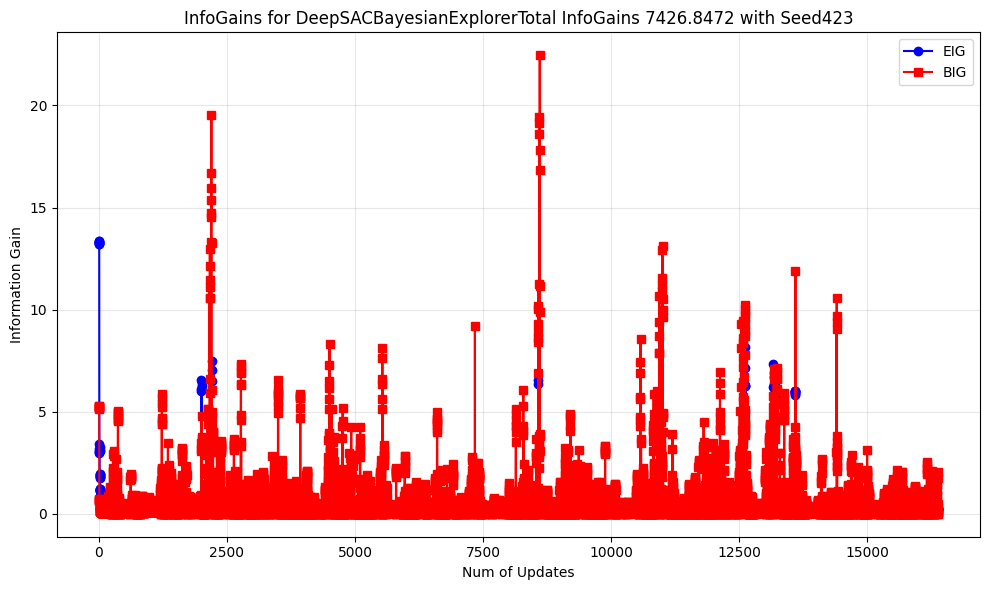

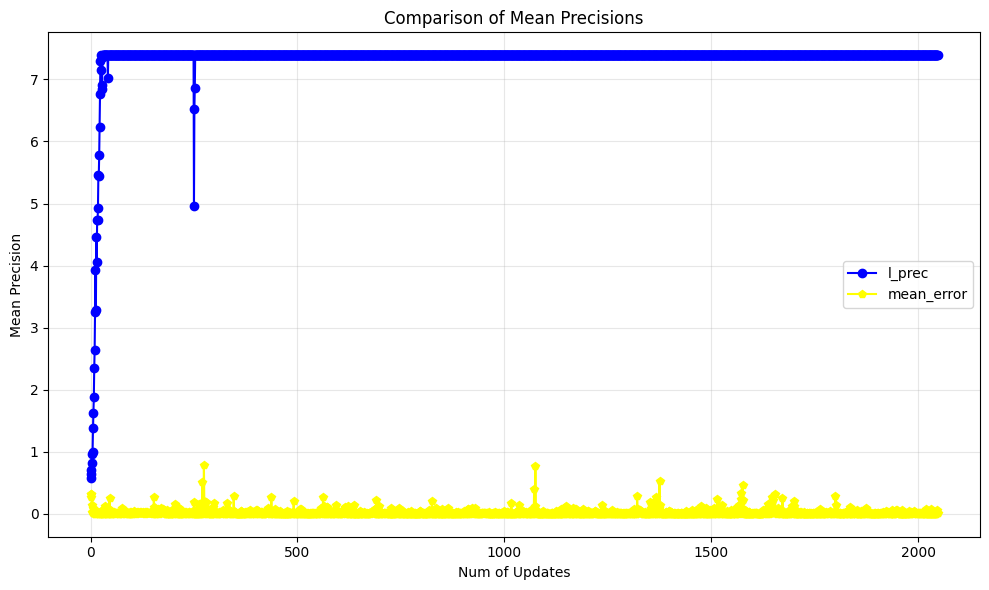

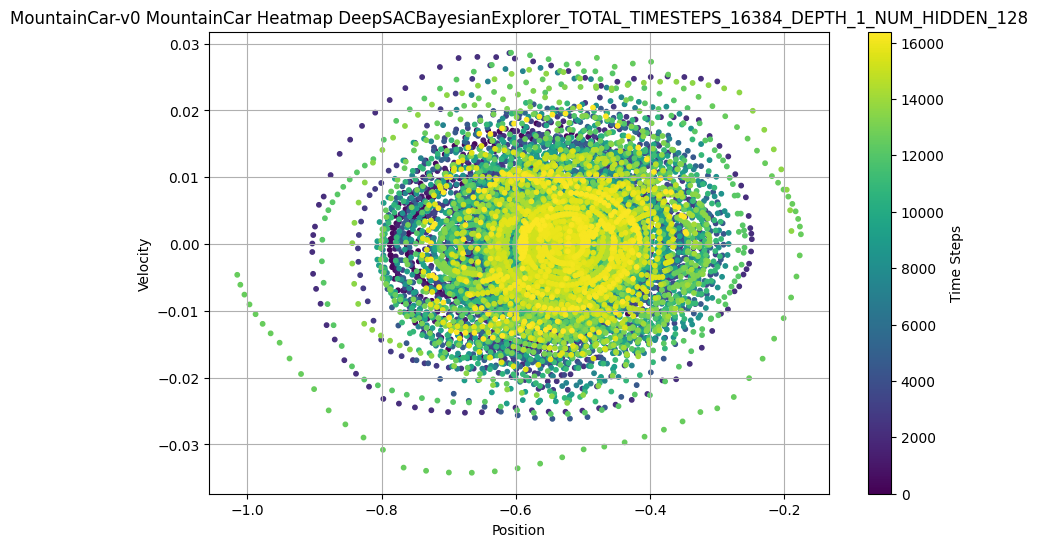

In [ ]:
#acrobot discrete continuous
#cartpole discrete continuous
#MountainCar discrete continuous

env_name = 'MountainCar-v0'  # @param ['CartPole-v1',"MountainCar-v0","Acrobot-v1"]
NUM_ENVS = 1 # @param [1,2,4,8,16] {"type":"raw"}
TOTAL_TIMESTEPS = 16384 # @param [2048,16384,131072,1048576] {"type":"raw"}
DEPTH = 1 # @param [1,2,4] {"type":"raw"}
NUM_STEPS = 8 # @param [1,2,4,8,16] {"type":"raw"}
NUM_HIDDEN = 128 # @param [32,64,128,256] {"type":"raw"}
WD = 0.1 # @param [0，0.1,0.01,0.001] {"type":"raw"}
MODEL_NAME = "DeepSACBayesianExplorer"  #@param ["DeepSACBayesianExplorer","RandomExplorer"]
config = {
    "NUM_ENVS": NUM_ENVS,    #
    "WD": WD,
    "NUM_STEPS": NUM_STEPS,   #steps of roll out between update
    "SAC_D_STEPS": 4,
    "ENV_NAME":env_name,
    "SAC_STEP_SIZE": 1.0,
    "SEED": 423,         #highly stochastic
    "TOTAL_TIMESTEPS": TOTAL_TIMESTEPS,   #total steps for all envs
    "NUM_HIDDEN":NUM_HIDDEN,
    "TX":"adamw",
    "DEPTH":DEPTH,
    "LR":2e-4,
    "OPT_STEPS":8,
    "MODEL_NAME": MODEL_NAME,
    "DEBUG": False,
}
#jax.config.update("jax_debug_nans", True)
#jax.config.update("jax_traceback_filtering", "off")
out = experiment(config)

In [ ]:
"""Visualization of gym environments."""

import gymnasium as gym
import numpy as np


def set_gym_params(gym_env, env_name, params):
    """Set gym environment parameters."""
    if env_name == "Acrobot-v1":
        gym_env.env.LINK_LENGTH_1 = params.link_length_1
        gym_env.env.LINK_LENGTH_2 = params.link_length_2
    elif env_name == "CartPole-v1":
        gym_env.env.x_threshold = params.x_threshold
        gym_env.env.length = params.length
    elif env_name == "Pendulum-v1":
        pass
    elif env_name == "MountainCar-v0" or env_name == "MountainCarContinuous-v0":
        gym_env.env.max_position = params.max_position
        gym_env.env.min_position = params.min_position
        gym_env.env.goal_position = params.goal_position
    return


def get_gym_state(state, env_name):
    """Get gym environment state."""
    if env_name == "Acrobot-v1":
        return np.array(
            [
                state.joint_angle1,
                state.joint_angle2,
                state.velocity_1,
                state.velocity_2,
            ]
        )
    elif env_name == "CartPole-v1":
        return np.array([state.x, state.x_dot, state.theta, state.theta_dot])
    elif env_name == "Pendulum-v1":
        return np.array([state.theta, state.theta_dot, state.last_u])
    elif env_name == "MountainCar-v0" or env_name == "MountainCarContinuous-v0":
        return np.array([state.position, state.velocity])


def init_gym(ax, env, state, params):
    """Initialize gym environment."""
    gym_env = gym.make(env.name,render_mode="rgb_array")
    gym_env.reset()
    set_gym_params(gym_env, env.name, params)
    gym_state = get_gym_state(state, env.name)
    if env.name == "Pendulum-v1":
        gym_env.env.last_u = gym_state[-1]
    gym_env.env.state = gym_state
    rgb_array = gym_env.render()
    ax.set_xticks([])
    ax.set_yticks([])
    gym_env.close()
    return ax.imshow(rgb_array)


def update_gym(im, env, state):
    """Update gym environment."""
    gym_env = gym.make(env.name,render_mode="rgb_array")
    gym_env.reset()
    gym_state = get_gym_state(state, env.name)
    if env.name == "Pendulum-v1":
        gym_env.env.last_u = gym_state[-1]
    gym_env.env.state = gym_state
    rgb_array = gym_env.render()
    im.set_data(rgb_array)
    gym_env.close()
    return im

/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


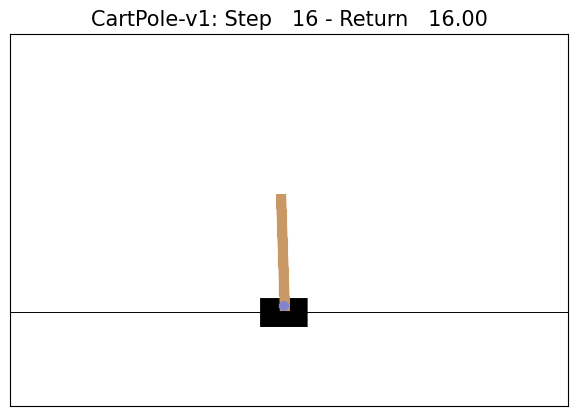

In [ ]:
"""Visualizer for Gymnax environments."""

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import animation

import gymnax
from gymnax.visualize import vis_catch, vis_circle, vis_maze, vis_minatar


class Visualizer:
    """Visualizer for Gymnax environments."""

    def __init__(self, env_arg, env_params_arg, state_seq_arg, reward_seq_arg=None):
        self.env = env_arg
        self.env_params = env_params_arg
        self.state_seq = state_seq_arg
        self.reward_seq = reward_seq_arg
        self.fig, self.ax = plt.subplots(1, 1, figsize=(6, 5))
        if env_arg.name not in [
            "Acrobot-v1",
            "CartPole-v1",
            "Pendulum-v1",
            "MountainCar-v0",
            "MountainCarContinuous-v0",
        ]:
            self.interval = 100
        else:
            self.interval = 50

    def animate(
        self,
        save_fname: str | None = "test.gif",
        view: bool = False,
    ):
        """Anim for 2D fct - x (#steps, #pop, 2) & fitness (#steps, #pop)."""
        ani = animation.FuncAnimation(
            self.fig,
            self.update,
            frames=len(self.state_seq),
            init_func=self.init,
            blit=False,
            interval=self.interval,
        )
        # Save the animation to a gif
        if save_fname is not None:
            ani.save(save_fname)
        # Simply view it 3 times
        if view:
            plt.show(block=False)
            plt.pause(3)
            plt.close()

    def init(self):
        """Plot placeholder points."""
        if self.env.name in [
            "Acrobot-v1",
            "CartPole-v1",
            "Pendulum-v1",
            "MountainCar-v0",
            "MountainCarContinuous-v0",
        ]:
            self.im = init_gym(
                self.ax, self.env, self.state_seq[0], self.env_params
            )
        elif self.env.name == "Catch-bsuite":
            self.im = vis_catch.init_catch(
                self.ax, self.env, self.state_seq[0], self.env_params
            )
        elif self.env.name in [
            "Asterix-MinAtar",
            "Breakout-MinAtar",
            "Freeway-MinAtar",
            "Seaquest-MinAtar",
            "SpaceInvaders-MinAtar",
            "Pong-misc",
        ]:
            self.im = vis_minatar.init_minatar(self.ax, self.env, self.state_seq[0])
        elif self.env.name == "PointRobot-misc":
            self.im = vis_circle.init_circle(
                self.ax, self.env, self.state_seq[0], self.env_params
            )
        elif self.env.name in ["MetaMaze-misc", "FourRooms-misc"]:
            self.im = vis_maze.init_maze(
                self.ax, self.env, self.state_seq[0], self.env_params
            )
        self.fig.tight_layout(rect=[0.02, 0.03, 1.0, 0.95])

    def update(self, frame):
        """Update the animation."""
        if self.env.name in [
            "Acrobot-v1",
            "CartPole-v1",
            "Pendulum-v1",
            "MountainCar-v0",
            "MountainCarContinuous-v0",
        ]:
            self.im = update_gym(self.im, self.env, self.state_seq[frame])
        elif self.env.name == "Catch-bsuite":
            self.im = vis_catch.update_catch(self.im, self.env, self.state_seq[frame])
        elif self.env.name in [
            "Asterix-MinAtar",
            "Breakout-MinAtar",
            "Freeway-MinAtar",
            "Seaquest-MinAtar",
            "SpaceInvaders-MinAtar",
            "Pong-misc",
        ]:
            vis_minatar.update_minatar(self.im, self.env, self.state_seq[frame])
        elif self.env.name == "PointRobot-misc":
            self.im = vis_circle.update_circle(self.im, self.env, self.state_seq[frame])
        elif self.env.name in ["MetaMaze-misc", "FourRooms-misc"]:
            self.im = vis_maze.update_maze(self.im, self.env, self.state_seq[frame])

        if self.reward_seq is None:
            self.ax.set_title(f"{self.env.name} - Step {frame + 1}", fontsize=15)
        else:
            # Construct the title string separately to avoid a long line
            title_str = (
                f"{self.env.name}: Step {frame + 1:4d}"
                f" - Return {self.reward_seq[frame]:7.2f}"
            )
            self.ax.set_title(
                title_str,
                fontsize=15,
            )


key = jax.random.key(0)
env, env_params = gymnax.make("CartPole-v1")

state_seq, reward_seq = [], []
key, key_reset = jax.random.split(key)
obs, env_state = env.reset(key_reset, env_params)
for i in range(16):
    state_seq.append(env_state)
    key, key_act, key_step = jax.random.split(key, 3)
    action = env.action_space(env_params).sample(key_act)
    next_obs, next_env_state, reward, done, info = env.step(
        key_step, env_state, action, env_params
    )
    reward_seq.append(reward)
    if done:
        break
    else:
        obs = next_obs
        env_state = next_env_state

cum_rewards = jnp.cumsum(jnp.array(reward_seq))
vis = Visualizer(env, env_params, state_seq, cum_rewards)
vis.animate(env_name+"_anim.gif")

env_name MountainCar-v0


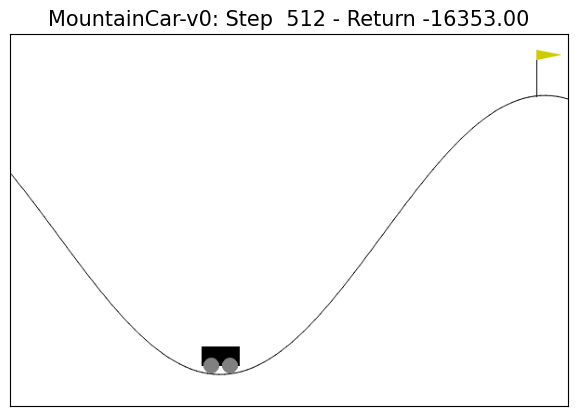

In [ ]:

print ("env_name",env_name)
env, env_params = gymnax.make(env_name)
states = unpack_states(out["states"])
rewards = unpack_states(out["transitions"].reward)

frequency = int(TOTAL_TIMESTEPS / NUM_ENVS / 512)
for state, reward_seq in zip(states,rewards):

    cum_rewards = jnp.cumsum(jnp.array(reward_seq))
    cum_rewards = [cum_rewards[i] for i in range(len(reward_seq)) if i % frequency == 0]
    state_seq = unpack_pytree_by_first_index(state)
    state_seq = [state_seq[i] for i in range(len(reward_seq)) if i % frequency == 0]
    vis = Visualizer(env, env_params, state_seq, cum_rewards)

    vis.animate(env_name+"_unsupervised_anim.gif")
    break

In [ ]:
# prompt: draw heatmap given sequence of states for MountainCar
#state.position, state.velocity
import matplotlib.pyplot as plt
def draw_mountain_car_heatmap(state_sequence):
    """
    Draws a heatmap representing the trajectory of the MountainCar environment.

    Args:
        state_sequence: A sequence of JAX arrays representing the states
                        of the MountainCar environment. Each state is expected
                        to be a 2-element array [position, velocity].
    """
    positions = [state.position for state in state_sequence]
    velocities = [state.velocity  for state in state_sequence]

    plt.figure(figsize=(10, 6))
    plt.scatter(positions, velocities, c=range(len(state_sequence)), cmap='viridis', s=10)
    plt.colorbar(label='Time Steps')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('MountainCar State Trajectory Heatmap')
    plt.grid(True)
    plt.show()

# Assuming 'states' contains a list of unpacked state sequences, one for each environment
# We will draw a heatmap for the first environment's trajectory as an example
if states:
    # Iterate through each state sequence and draw a heatmap
    for i, env_states in enumerate(states):
      draw_mountain_car_heatmap(states)

NameError: name 'states' is not defined

In [ ]:





def make_test(config):

    config["NUM_UPDATES"] = (config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"]// config["NUM_ENVS"])

    rng = jax.random.PRNGKey(config["SEED"])
    rng_batch = jax.random.split(rng, config["NUM_ENVS"])

    manager = UnsupervisedRolloutWrapper(config["ENV_NAME"])
    action_dim = manager.env.action_space(manager.env_params).shape[0]
    obs_dim = manager.env.observation_space(manager.env_params).shape[0]
    model = DeepSACBayesianExplorer(obs_dim, action_dim,config["NUM_HIDDEN"], nnx.Rngs(config["SEED"]),weight_decay=config["WD"])

    @nnx.jit
    def _rollout_and_update_step(runner_state, unused):
        # we have to use train_state for jax.lax.scan
        train_state,  rng_batch = runner_state

        model = model_from_train_state(train_state)
        rng_batch, rng_step,rng_update,rng_loss = batch_random_split(rng_batch,4)

        rollout_results = manager.batch_rollout( rng_batch,model,num_steps =  config["NUM_STEPS"])
        obs, action, reward, next_obs, done,info, cum_ret = rollout_results
        # obs: num_envs x
        transition = Transition(obs, action, reward, next_obs, done,info)

        update_info = manager.batch_update(rng_update, model,obs, action,next_obs,done,info)
        info.update(update_info)
        train_state = train_state_update_model(model,train_state)

        if train_state.need_train:
            train_state = _train_step(train_state, rng_loss, obs, action,next_obs,done,info)

        #works for tensors
        runner_state = (train_state, rng_batch)
        return runner_state, transition

    def train(rng_batch,model,manager):
        # training loop

        rng_batch,  rng_reset = batch_random_split(rng_batch, 2)
   #     start_state = manager.batch_reset(rng_reset)

        if config["TX"] == "adamw":
            tx = optax.adamw(config["LR"])
        elif config["TX"] == "sgd":
            tx = optax.sgd(config["LR"])
        else:
            tx = None
            assert False, config["TX"] + " is not avaliable"
        train_state = train_state_from_model(model,tx)
      #  rng, _rng = jax.random.split(rng)
        runner_state = (train_state,  rng_batch)
        runner_state, transitions = jax.lax.scan(_rollout_and_update_step, runner_state, None, config["NUM_UPDATES"])

        return {"runner_state": runner_state, "transitions": transitions}
        # return {"runner_state": runner_state, "collect_data": collect_data, "max_mi_history": max_mi_history}

    return train,model, manager,rng_batch

In [ ]:
# source https://github.com/ikostrikov/implicit_q_learning
# https://arxiv.org/abs/2110.06169
import os
import time
from functools import partial
from typing import Any, Callable, Dict, NamedTuple, Optional, Sequence, Tuple

import distrax
import flax
import flax.linen as nn
import gym
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tqdm
import wandb
from flax.training.train_state import TrainState
from omegaconf import OmegaConf
from pydantic import BaseModel

os.environ["XLA_FLAGS"] = "--xla_gpu_triton_gemm_any=True"


class IQLConfig(BaseModel):
    # GENERAL
    algo: str = "IQL"
    project: str = "train-IQL"
    env_name: str = "halfcheetah-medium-expert-v2"
    seed: int = 42
    eval_episodes: int = 5
    log_interval: int = 100000
    eval_interval: int = 100000
    batch_size: int = 256
    max_steps: int = int(1e6)
    n_jitted_updates: int = 8
    # DATASET
    data_size: int = int(1e6)
    normalize_state: bool = False
    normalize_reward: bool = True
    # NETWORK
    hidden_dims: Tuple[int, int] = (256, 256)
    actor_lr: float = 3e-4
    value_lr: float = 3e-4
    critic_lr: float = 3e-4
    layer_norm: bool = True
    opt_decay_schedule: bool = True
    # IQL SPECIFIC
    expectile: float = (
        0.7  # FYI: for Hopper-me, 0.5 produce better result. (antmaze: expectile=0.9)
    )
    beta: float = (
        3.0  # FYI: for Hopper-me, 6.0 produce better result. (antmaze: beta=10.0)
    )
    tau: float = 0.005
    discount: float = 0.99

    def __hash__(
        self,
    ):  # make config hashable to be specified as static_argnums in jax.jit.
        return hash(self.__repr__())


conf_dict = OmegaConf.from_cli()
config = IQLConfig(**conf_dict)


def default_init(scale: Optional[float] = jnp.sqrt(2)):
    return nn.initializers.orthogonal(scale)


class MLP(nn.Module):
    hidden_dims: Sequence[int]
    activations: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    activate_final: bool = False
    kernel_init: Callable[[Any, Sequence[int], Any], jnp.ndarray] = default_init()
    layer_norm: bool = False

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for i, hidden_dims in enumerate(self.hidden_dims):
            x = nn.Dense(hidden_dims, kernel_init=self.kernel_init)(x)
            if i + 1 < len(self.hidden_dims) or self.activate_final:
                if self.layer_norm:  # Add layer norm after activation
                    x = nn.LayerNorm()(x)
                x = self.activations(x)
        return x


class Critic(nn.Module):
    hidden_dims: Sequence[int]
    activations: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu

    @nn.compact
    def __call__(self, observations: jnp.ndarray, actions: jnp.ndarray) -> jnp.ndarray:
        inputs = jnp.concatenate([observations, actions], -1)
        critic = MLP((*self.hidden_dims, 1), activations=self.activations)(inputs)
        return jnp.squeeze(critic, -1)


def ensemblize(cls, num_qs, out_axes=0, **kwargs):
    split_rngs = kwargs.pop("split_rngs", {})
    return nn.vmap(
        cls,
        variable_axes={"params": 0},
        split_rngs={**split_rngs, "params": True},
        in_axes=None,
        out_axes=out_axes,
        axis_size=num_qs,
        **kwargs,
    )


class ValueCritic(nn.Module):
    hidden_dims: Sequence[int]
    layer_norm: bool = False

    @nn.compact
    def __call__(self, observations: jnp.ndarray) -> jnp.ndarray:
        critic = MLP((*self.hidden_dims, 1), layer_norm=self.layer_norm)(observations)
        return jnp.squeeze(critic, -1)


class GaussianPolicy(nn.Module):
    hidden_dims: Sequence[int]
    action_dim: int
    log_std_min: Optional[float] = -5.0
    log_std_max: Optional[float] = 2

    @nn.compact
    def __call__(
        self, observations: jnp.ndarray, temperature: float = 1.0
    ) -> distrax.Distribution:
        outputs = MLP(
            self.hidden_dims,
            activate_final=True,
        )(observations)

        means = nn.Dense(
            self.action_dim, kernel_init=default_init()
        )(outputs)
        log_stds = self.param("log_stds", nn.initializers.zeros, (self.action_dim,))
        log_stds = jnp.clip(log_stds, self.log_std_min, self.log_std_max)

        distribution = distrax.MultivariateNormalDiag(
            loc=means, scale_diag=jnp.exp(log_stds) * temperature
        )
        return distribution


class Transition(NamedTuple):
    observations: jnp.ndarray
    actions: jnp.ndarray
    rewards: jnp.ndarray
    next_observations: jnp.ndarray
    dones: jnp.ndarray
    dones_float: jnp.ndarray


def get_normalization(dataset: Transition) -> float:
    # into numpy.ndarray
    dataset = jax.tree_util.tree_map(lambda x: np.array(x), dataset)
    returns = []
    ret = 0
    for r, term in zip(dataset.rewards, dataset.dones_float):
        ret += r
        if term:
            returns.append(ret)
            ret = 0
    return (max(returns) - min(returns)) / 1000


def get_dataset(
    env: gym.Env, config: IQLConfig, clip_to_eps: bool = True, eps: float = 1e-5
) -> Transition:
    dataset = d4rl.qlearning_dataset(env)

    if clip_to_eps:
        lim = 1 - eps
        dataset["actions"] = np.clip(dataset["actions"], -lim, lim)

    dones_float = np.zeros_like(dataset['rewards'])

    for i in range(len(dones_float) - 1):
        if np.linalg.norm(dataset['observations'][i + 1] -
                            dataset['next_observations'][i]
                            ) > 1e-6 or dataset['terminals'][i] == 1.0:
            dones_float[i] = 1
        else:
            dones_float[i] = 0
    dones_float[-1] = 1

    dataset = Transition(
        observations=jnp.array(dataset["observations"], dtype=jnp.float32),
        actions=jnp.array(dataset["actions"], dtype=jnp.float32),
        rewards=jnp.array(dataset["rewards"], dtype=jnp.float32),
        next_observations=jnp.array(dataset["next_observations"], dtype=jnp.float32),
        dones=jnp.array(dataset["terminals"], dtype=jnp.float32),
        dones_float=jnp.array(dones_float, dtype=jnp.float32),
    )
    if "antmaze" in config.env_name:
        dataset = dataset._replace(
            rewards=dataset.rewards - 1.0
        )
    # normalize states
    obs_mean, obs_std = 0, 1
    if config.normalize_state:
        obs_mean = dataset.observations.mean(0)
        obs_std = dataset.observations.std(0)
        dataset = dataset._replace(
            observations=(dataset.observations - obs_mean) / (obs_std + 1e-5),
            next_observations=(dataset.next_observations - obs_mean) / (obs_std + 1e-5),
        )
    # normalize rewards
    if config.normalize_reward:
        normalizing_factor = get_normalization(dataset)
        dataset = dataset._replace(rewards=dataset.rewards / normalizing_factor)

    # shuffle data and select the first data_size samples
    data_size = min(config.data_size, len(dataset.observations))
    rng = jax.random.PRNGKey(config.seed)
    rng, rng_permute, rng_select = jax.random.split(rng, 3)
    perm = jax.random.permutation(rng_permute, len(dataset.observations))
    dataset = jax.tree_util.tree_map(lambda x: x[perm], dataset)
    assert len(dataset.observations) >= data_size
    dataset = jax.tree_util.tree_map(lambda x: x[:data_size], dataset)
    return dataset, obs_mean, obs_std


def expectile_loss(diff, expectile=0.8) -> jnp.ndarray:
    weight = jnp.where(diff > 0, expectile, (1 - expectile))
    return weight * (diff**2)


def target_update(
    model: TrainState, target_model: TrainState, tau: float
) -> TrainState:
    new_target_params = jax.tree_util.tree_map(
        lambda p, tp: p * tau + tp * (1 - tau), model.params, target_model.params
    )
    return target_model.replace(params=new_target_params)


def update_by_loss_grad(
    train_state: TrainState, loss_fn: Callable
) -> Tuple[TrainState, jnp.ndarray]:
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(train_state.params)
    new_train_state = train_state.apply_gradients(grads=grad)
    return new_train_state, loss


class IQLTrainState(NamedTuple):
    rng: jax.random.PRNGKey
    critic: TrainState
    target_critic: TrainState
    value: TrainState
    actor: TrainState


class IQL(object):

    @classmethod
    def update_critic(
        self, train_state: IQLTrainState, batch: Transition, config: IQLConfig
    ) -> Tuple["IQLTrainState", Dict]:
        next_v = train_state.value.apply_fn(
            train_state.value.params, batch.next_observations
        )
        target_q = batch.rewards + config.discount * (1 - batch.dones) * next_v

        def critic_loss_fn(
            critic_params: flax.core.FrozenDict[str, Any]
        ) -> jnp.ndarray:
            q1, q2 = train_state.critic.apply_fn(
                critic_params, batch.observations, batch.actions
            )
            critic_loss = ((q1 - target_q) ** 2 + (q2 - target_q) ** 2).mean()
            return critic_loss

        new_critic, critic_loss = update_by_loss_grad(
            train_state.critic, critic_loss_fn
        )
        return train_state._replace(critic=new_critic), critic_loss

    @classmethod
    def update_value(
        self, train_state: IQLTrainState, batch: Transition, config: IQLConfig
    ) -> Tuple["IQLTrainState", Dict]:
        q1, q2 = train_state.target_critic.apply_fn(
            train_state.target_critic.params, batch.observations, batch.actions
        )
        q = jax.lax.stop_gradient(jnp.minimum(q1, q2))
        def value_loss_fn(value_params: flax.core.FrozenDict[str, Any]) -> jnp.ndarray:
            v = train_state.value.apply_fn(value_params, batch.observations)
            value_loss = expectile_loss(q - v, config.expectile).mean()
            return value_loss

        new_value, value_loss = update_by_loss_grad(train_state.value, value_loss_fn)
        return train_state._replace(value=new_value), value_loss

    @classmethod
    def update_actor(
        self, train_state: IQLTrainState, batch: Transition, config: IQLConfig
    ) -> Tuple["IQLTrainState", Dict]:
        v = train_state.value.apply_fn(train_state.value.params, batch.observations)
        q1, q2 = train_state.critic.apply_fn(
            train_state.target_critic.params, batch.observations, batch.actions
        )
        q = jnp.minimum(q1, q2)
        exp_a = jnp.exp((q - v) * config.beta)
        exp_a = jnp.minimum(exp_a, 100.0)
        def actor_loss_fn(actor_params: flax.core.FrozenDict[str, Any]) -> jnp.ndarray:
            dist = train_state.actor.apply_fn(actor_params, batch.observations)
            log_probs = dist.log_prob(batch.actions)
            actor_loss = -(exp_a * log_probs).mean()
            return actor_loss

        new_actor, actor_loss = update_by_loss_grad(train_state.actor, actor_loss_fn)
        return train_state._replace(actor=new_actor), actor_loss

    @classmethod
    def update_n_times(
        self,
        train_state: IQLTrainState,
        dataset: Transition,
        rng: jax.random.PRNGKey,
        config: IQLConfig,
    ) -> Tuple["IQLTrainState", Dict]:
        for _ in range(config.n_jitted_updates):
            rng, subkey = jax.random.split(rng)
            batch_indices = jax.random.randint(
                subkey, (config.batch_size,), 0, len(dataset.observations)
            )
            batch = jax.tree_util.tree_map(lambda x: x[batch_indices], dataset)

            train_state, value_loss = self.update_value(train_state, batch, config)
            train_state, actor_loss = self.update_actor(train_state, batch, config)
            train_state, critic_loss = self.update_critic(train_state, batch, config)
            new_target_critic = target_update(
                train_state.critic, train_state.target_critic, config.tau
            )
            train_state = train_state._replace(target_critic=new_target_critic)
        return train_state, {
            "value_loss": value_loss,
            "actor_loss": actor_loss,
            "critic_loss": critic_loss,
        }

    @classmethod
    def get_action(
        self,
        train_state: IQLTrainState,
        observations: np.ndarray,
        seed: jax.random.PRNGKey,
        temperature: float = 1.0,
        max_action: float = 1.0,  # In D4RL, the action space is [-1, 1]
    ) -> jnp.ndarray:
        actions = train_state.actor.apply_fn(
            train_state.actor.params, observations, temperature=temperature
        ).sample(seed=seed)
        actions = jnp.clip(actions, -max_action, max_action)
        return actions


def create_iql_train_state(
    rng: jax.random.PRNGKey,
    observations: jnp.ndarray,
    actions: jnp.ndarray,
    config: IQLConfig,
) -> IQLTrainState:
    rng, actor_rng, critic_rng, value_rng = jax.random.split(rng, 4)
    # initialize actor
    action_dim = actions.shape[-1]
    actor_model = GaussianPolicy(
        config.hidden_dims,
        action_dim=action_dim,
        log_std_min=-5.0,
    )
    if config.opt_decay_schedule:
        schedule_fn = optax.cosine_decay_schedule(-config.actor_lr, config.max_steps)
        actor_tx = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(schedule_fn))
    else:
        actor_tx = optax.adam(learning_rate=config.actor_lr)
    actor = TrainState.create(
        apply_fn=actor_model.apply,
        params=actor_model.init(actor_rng, observations),
        tx=actor_tx,
    )
    # initialize critic
    critic_model = ensemblize(Critic, num_qs=2)(config.hidden_dims)
    critic = TrainState.create(
        apply_fn=critic_model.apply,
        params=critic_model.init(critic_rng, observations, actions),
        tx=optax.adam(learning_rate=config.critic_lr),
    )
    target_critic = TrainState.create(
        apply_fn=critic_model.apply,
        params=critic_model.init(critic_rng, observations, actions),
        tx=optax.adam(learning_rate=config.critic_lr),
    )
    # initialize value
    value_model = ValueCritic(config.hidden_dims, layer_norm=config.layer_norm)
    value = TrainState.create(
        apply_fn=value_model.apply,
        params=value_model.init(value_rng, observations),
        tx=optax.adam(learning_rate=config.value_lr),
    )
    return IQLTrainState(
        rng,
        critic=critic,
        target_critic=target_critic,
        value=value,
        actor=actor,
    )


def evaluate(
    policy_fn, env: gym.Env, num_episodes: int, obs_mean: float, obs_std: float
) -> float:
    episode_returns = []
    for _ in range(num_episodes):
        episode_return = 0
        observation, done = env.reset(), False
        while not done:
            observation = (observation - obs_mean) / (obs_std + 1e-5)
            action = policy_fn(observations=observation)
            observation, reward, done, info = env.step(action)
            episode_return += reward
        episode_returns.append(episode_return)
    return env.get_normalized_score(np.mean(episode_returns)) * 100


if __name__ == "__main__":
    wandb.init(config=config, project=config.project)
    rng = jax.random.PRNGKey(config.seed)
    env = gym.make(config.env_name)
    dataset, obs_mean, obs_std = get_dataset(env, config)
    # create train_state
    rng, subkey = jax.random.split(rng)
    example_batch: Transition = jax.tree_util.tree_map(lambda x: x[0], dataset)
    train_state: IQLTrainState = create_iql_train_state(
        subkey,
        example_batch.observations,
        example_batch.actions,
        config,
    )

    algo = IQL()
    update_fn = jax.jit(algo.update_n_times, static_argnums=(3,))
    act_fn = jax.jit(algo.get_action)
    num_steps = config.max_steps // config.n_jitted_updates
    eval_interval = config.eval_interval // config.n_jitted_updates
    for i in tqdm.tqdm(range(1, num_steps + 1), smoothing=0.1, dynamic_ncols=True):
        rng, subkey = jax.random.split(rng)
        train_state, update_info = update_fn(train_state, dataset, subkey, config)

        if i % config.log_interval == 0:
            train_metrics = {f"training/{k}": v for k, v in update_info.items()}
            wandb.log(train_metrics, step=i)

        if i % eval_interval == 0:
            policy_fn = partial(
                act_fn,
                temperature=0.0,
                seed=jax.random.PRNGKey(0),
                train_state=train_state,
            )
            normalized_score = evaluate(
                policy_fn,
                env,
                num_episodes=config.eval_episodes,
                obs_mean=obs_mean,
                obs_std=obs_std,
            )
            print(i, normalized_score)
            eval_metrics = {f"{config.env_name}/normalized_score": normalized_score}
            wandb.log(eval_metrics, step=i)
    # final evaluation
    policy_fn = partial(
        act_fn,
        temperature=0.0,
        seed=jax.random.PRNGKey(0),
        train_state=train_state,
    )
    normalized_score = evaluate(
        policy_fn,
        env,
        num_episodes=config.eval_episodes,
        obs_mean=obs_mean,
        obs_std=obs_std,
    )
    print("Final Evaluation", normalized_score)
    wandb.log({f"{config.env_name}/final_normalized_score": normalized_score})
    wandb.finish()

/usr/local/lib/python3.11/dist-packages/Cython/Distutils/old_build_ext.py:14: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group

You appear to be missing MuJoCo.  We expected to find the file here: /root/.mujoco/mujoco210

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html



Exception: 
You appear to be missing MuJoCo.  We expected to find the file here: /root/.mujoco/mujoco210

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html
